   Edited by Sizhuo Li
   
   Author: Ankit Kariryaa, University of Bremen

### Overview 
Start by labeling/annotating a part of the satellite images with the trees or any other object of interest. Store the labels in shapefiles. The areas that are labeled/annotated are denoted by the 'training area' and actual trees or the object of interests in that area are denoted by the 'training polygons'. The word annotation and label are used interchangeably in this code. 

In this notebook, first, we read the training area and the training polygons from two separate shape files. Then we determine the training area for each training polygon and generate a weighted boundary for each training area. 
Next, we read the raw satellite images (ndvi and pan channel), and from each satellite image, we extract areas that overlap with a training area. The part of the ndvi and pan image that overlap with the training area and the corresponding label/annotation and boundary weights are then written to separate files.

Here, the term training area and training polygon represent all available input data, which can then be separated into training, validation, and test sets in the next notebook(s). 

### Getting started
Create a new `notebooks/config/` directory by copying the `notebooks/configTemplate/` directory and define the paths to input and output data in the `notebooks/config/Preprocessing.py` file.  
Note that in `notebooks/config/Preprocessing.py` you may need to change the default value of some variable (e.g., `raw_image_file_type` or `bands`) for your specific use case.

In [1]:
import rasterio                  # I/O raster data (netcdf, height, geotiff, ...)
import rasterio.mask
import rasterio.warp             # Reproject raster samples
import rasterio.merge
from rasterio.transform import rowcol
import fiona                     # I/O vector data (shape, geojson, ...)
import pyproj                    # Change coordinate reference system
import geopandas as gps
import pandas as pd
import shapely
from shapely.geometry import box, Point
import json

import numpy as np               # numerical array manipulation
import time
import os
from PIL import Image
import PIL.ImageDraw
from core.visualize import display_images
from core.frame_info import image_normalize

import matplotlib.pyplot as plt  # plotting tools
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Required configurations (including the input and output paths) are stored in a separate file (such as config/Preprocessing.py)
# Please provide required info in the file before continuing with this notebook. 
 
from config import Preprocessing
# In case you are using a different folder name such as configLargeCluster, then you should import from the respective folder 
# Eg. from configLargeCluster import Preprocessing

config = Preprocessing.Configuration()

In [3]:
#Read the training area and training polygons
trainingArea = gps.read_file(os.path.join(config.training_base_dir, config.training_area_fn))
trainingPolygon = gps.read_file(os.path.join(config.training_base_dir, config.training_polygon_fn))

print(f'Read a total of {trainingPolygon.shape[0]} object polygons and {trainingArea.shape[0]} training areas.')
print(f'Polygons will be assigned to training areas in the next steps.')

Read a total of 7496 object polygons and 3 training areas.
Polygons will be assigned to training areas in the next steps.


In [4]:
#Check if the training areas and the training polygons have the same crs
if trainingArea.crs  != trainingPolygon.crs:
    print('Training area CRS does not match training_polygon CRS')
    targetCRS = trainingPolygon.crs #Areas are less in number so conversion should be faster
    trainingArea = trainingArea.to_crs(targetCRS)
print(trainingPolygon.crs)
print(trainingArea.crs)
assert trainingPolygon.crs == trainingArea.crs

epsg:26913
epsg:26913


In [5]:
# Assign serial IDs to training areas
trainingArea['id'] = range(trainingArea.shape[0])
trainingArea

,id,geometry
0,0,"POLYGON ((615524.693 3636296.701, 615524.693 3..."
1,1,"POLYGON ((616081.277 3633835.363, 616081.277 3..."
2,2,"POLYGON ((611730.646 3636005.267, 611730.646 3..."


In [6]:
# Create boundary from polygon file
def calculateBoundaryWeight(polygonsInArea, scale_polygon = 1.5, output_plot = True): 
    '''
    For each polygon, create a weighted boundary where the weights of shared/close boundaries is higher than weights of solitary boundaries.
    '''
    # If there are polygons in a area, the boundary polygons return an empty geo dataframe
    if not polygonsInArea:
        return gps.GeoDataFrame({})
    tempPolygonDf = pd.DataFrame(polygonsInArea)
    tempPolygonDf.reset_index(drop=True,inplace=True)
    tempPolygonDf = gps.GeoDataFrame(tempPolygonDf.drop(columns=['id']))
    new_c = []
    #for each polygon in area scale, compare with other polygons:
    for i in tqdm(range(len(tempPolygonDf))):
        pol1 = gps.GeoSeries(tempPolygonDf.iloc[i][0])
        sc = pol1.scale(xfact=scale_polygon, yfact=scale_polygon, zfact=scale_polygon, origin='center')
        scc = pd.DataFrame(columns=['id', 'geometry'])
        scc = scc.append({'id': None, 'geometry': sc[0]}, ignore_index=True)
        scc = gps.GeoDataFrame(pd.concat([scc]*len(tempPolygonDf), ignore_index=True))

        pol2 = gps.GeoDataFrame(tempPolygonDf[~tempPolygonDf.index.isin([i])])
        #scale pol2 also and then intersect, so in the end no need for scale
        pol2 = gps.GeoDataFrame(pol2.scale(xfact=scale_polygon, yfact=scale_polygon, zfact=scale_polygon, origin='center'))
        pol2.columns = ['geometry']

        ints = scc.intersection(pol2)
        for k in range(len(ints)):
            if ints.iloc[k]!=None:
                if ints.iloc[k].is_empty !=1:
                    new_c.append(ints.iloc[k])
    new_c = gps.GeoSeries(new_c)
    new_cc = gps.GeoDataFrame({'geometry': new_c})
    new_cc.columns = ['geometry']
    bounda = gps.overlay(new_cc, tempPolygonDf, how='difference')
    if output_plot:
        fig, ax = plt.subplots(figsize = (10,10))
        bounda.plot(ax=ax,color = 'red')
        plt.show()
    #change multipolygon to polygon
    bounda = bounda.explode()
    bounda.reset_index(drop=True,inplace=True)
    #bounda.to_file('boundary_ready_to_use.shp')
    return bounda

In [7]:
# As input we received two shapefile, first one contains the training areas/rectangles and other contains the polygon of trees/objects in those training areas
# The first task is to determine the parent training area for each polygon and generate a weight map based upon the distance of a polygon boundary to other objects.
# Weight map will be used by the weighted loss during the U-Net training

def dividePolygonsInTrainingAreas(trainingPolygon, trainingArea):
    '''
    Assign annotated ploygons in to the training areas.
    '''
    # For efficiency, assigned polygons are removed from the list, we make a copy here. 
    cpTrainingPolygon = trainingPolygon.copy()
    print(len(cpTrainingPolygon))
    splitPolygons = {}
    for i in tqdm(trainingArea.index):
        spTemp = []
        allocated = []
        for j in cpTrainingPolygon.index:
            if trainingArea.loc[i]['geometry'].intersects(cpTrainingPolygon.loc[j]['geometry']):
                spTemp.append(cpTrainingPolygon.loc[j])
                allocated.append(j)

            # Order of bounds: minx miny maxx maxy
        boundary = calculateBoundaryWeight(spTemp, scale_polygon = 1.5, output_plot = config.show_boundaries_during_processing)
        splitPolygons[trainingArea.loc[i]['id']] = {'polygons':spTemp, 'boundaryWeight': boundary, 'bounds':list(trainingArea.bounds.loc[i]),}
        cpTrainingPolygon = cpTrainingPolygon.drop(allocated)
    return splitPolygons

# areasWithPolygons contains the object polygons and weighted boundaries for each area!
areasWithPolygons = dividePolygonsInTrainingAreas(trainingPolygon, trainingArea)
print(f'Assigned training polygons in {len(areasWithPolygons)} training areas and created weighted boundaries for ploygons')

7496


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1866 [00:00<?, ?it/s]

  0%|          | 0/2952 [00:00<?, ?it/s]

  0%|          | 0/2678 [00:00<?, ?it/s]

Assigned training polygons in 3 training areas and created weighted boundaries for ploygons


In [8]:
# Read the raw input images
def readInputImages(imageBaseDir, rawImageFileType, rawNdviImagePrefix, rawPanImagePrefix):
    """
    Reads all images with prefix ndvi_image_prefix and image_file_type datatype in the image_base_dir directory.
    """     
    
    ndviImageFn = []
    for root, dirs, files in os.walk(imageBaseDir):
        for file in files:
            if file.endswith(rawImageFileType) and file.startswith(rawNdviImagePrefix):
                 ndviImageFn.append(os.path.join(root, file))
    panImageFn = [fn.replace(rawNdviImagePrefix, rawPanImagePrefix) for fn in ndviImageFn]
    inputImages = list(zip(ndviImageFn,panImageFn))
    return inputImages

inputImages = readInputImages(config.raw_image_base_dir, config.raw_image_file_type, config.raw_ndvi_image_prefix, config.raw_pan_image_prefix)
print(f'Found a total of {len(inputImages)} pair of raw image(s) to process!')

Found a total of 1 pair of raw image(s) to process!


In [9]:
# For each raw satellite image, determine if it overlaps with a training area. 
# If a overlap if found, then extract + write the overlapping part of the raw image, create + write an image from training polygons and create + write an image from boundary weights in the that overlapping region.

def drawPolygons(polygons, shape, outline, fill):
    """
    From the polygons, create a numpy mask with fill value in the foreground and 0 value in the background.
    Outline (i.e the edge of the polygon) can be assigned a separate value.
    """
    mask = np.zeros(shape, dtype=np.uint8)
    mask = PIL.Image.fromarray(mask)
    draw = PIL.ImageDraw.Draw(mask)
    #Syntax: PIL.ImageDraw.Draw.polygon(xy, fill=None, outline=None)
    #Parameters:
    #xy – Sequence of either 2-tuples like [(x, y), (x, y), …] or numeric values like [x, y, x, y, …].
    #outline – Color to use for the outline.
    #fill – Color to use for the fill.
    #Returns: An Image object.
    for polygon in polygons:
        xy = [(point[1], point[0]) for point in polygon]
        draw.polygon(xy=xy, outline=outline, fill=fill)
    mask = np.array(mask)#, dtype=bool)   
    return(mask)


def rowColPolygons(areaDf, areaShape, profile, filename, outline, fill):
    """
    Convert polygons coordinates to image pixel coordinates, create annotation image using drawPolygons() and write the results into an image file.
    """
    transform = profile['transform']
    polygons = []
    for i in areaDf.index:
        gm = areaDf.loc[i]['geometry']
        a,b = zip(*list(gm.exterior.coords))
        row, col = rasterio.transform.rowcol(transform, a, b)
        zipped = list(zip(row,col)) #[list(rc) for rc in list(zip(row,col))]
        polygons.append(zipped)
    with open(filename, 'w') as outfile:  
        json.dump({'Trees': polygons}, outfile)
    mask = drawPolygons(polygons,areaShape, outline=outline, fill=fill)    
    profile['dtype'] = rasterio.int16
    with rasterio.open(filename.replace('json', 'png'), 'w', **profile) as dst:
        dst.write(mask.astype(rasterio.int16), 1)

def writeExtractedImageAndAnnotation(img, sm, profile, polygonsInAreaDf, boundariesInAreaDf, writePath, imagesFilename, annotationFilename, boundaryFilename, bands, writeCounter, normalize=True):
    """
    Write the part of raw image that overlaps with a training area into a separate image file. 
    Use rowColPolygons to create and write annotation and boundary image from polygons in the training area.
    """
    try:
        for band, imFn in zip(bands, imagesFilename):
            # Rasterio reads file channel first, so the sm[0] has the shape [1 or ch_count, x,y]
            # If raster has multiple channels, then bands will be [0, 1, ...] otherwise simply [0]
            dt = sm[0][band].astype(profile['dtype'])
            if normalize: # Note: If the raster contains None values, then you should normalize it separately by calculating the mean and std without those values.
                dt = image_normalize(dt, axis=None) #  Normalize the image along the width and height, and since here we only have one channel we pass axis as None
            with rasterio.open(os.path.join(writePath, imFn+'_{}.png'.format(writeCounter)), 'w', **profile) as dst:
                    dst.write(dt, 1) 
        if annotationFilename:
            annotation_json_filepath = os.path.join(writePath,annotationFilename+'_{}.json'.format(writeCounter))
            # The object is given a value of 1, the outline or the border of the object is given a value of 0 and rest of the image/background is given a a value of 0
            rowColPolygons(polygonsInAreaDf,(sm[0].shape[1], sm[0].shape[2]), profile, annotation_json_filepath, outline=0, fill = 1)
        if boundaryFilename:
            boundary_json_filepath = os.path.join(writePath,boundaryFilename+'_{}.json'.format(writeCounter))
            # The boundaries are given a value of 1, the outline or the border of the boundaries is also given a value of 1 and rest is given a value of 0
            rowColPolygons(boundariesInAreaDf,(sm[0].shape[1], sm[0].shape[2]), profile, boundary_json_filepath, outline=1 , fill=1)
        return(writeCounter+1)
    except Exception as e:
        print(e)
        print("Something nasty happened, could not write the annotation or the mask file!")
        return writeCounter
        
        
def findOverlap(img, areasWithPolygons, writePath, imageFilename, annotationFilename, boundaryFilename, bands, writeCounter=1):
    """
    Finds overlap of image with a training area.
    Use writeExtractedImageAndAnnotation() to write the overlapping training area and corresponding polygons in separate image files.
    """
    overlapppedAreas = set()
    for areaID, areaInfo in areasWithPolygons.items():
        #Convert the polygons in the area in a dataframe and get the bounds of the area. 
        polygonsInAreaDf = gps.GeoDataFrame(areaInfo['polygons'])
        boundariesInAreaDf = gps.GeoDataFrame(areaInfo['boundaryWeight'])    
        bboxArea = box(*areaInfo['bounds'])
        bboxImg = box(*img.bounds)
        #Extract the window if area is in the image
        if(bboxArea.intersects(bboxImg)):
            profile = img.profile  
            sm = rasterio.mask.mask(img, [bboxArea], all_touched=True, crop=True )
            profile['height'] = sm[0].shape[1]
            profile['width'] = sm[0].shape[2]
            profile['transform'] = sm[1]
            # That's a problem with rasterio, if the height and the width are less then 256 it throws: ValueError: blockysize exceeds raster height 
            # So I set the blockxsize and blockysize to prevent this problem
            profile['blockxsize'] = 32
            profile['blockysize'] = 32
            profile['count'] = 1
            profile['dtype'] = rasterio.float32
            # writeExtractedImageAndAnnotation writes the image, annotation and boundaries and returns the counter of the next file to write. 
            writeCounter = writeExtractedImageAndAnnotation(img, sm, profile, polygonsInAreaDf, boundariesInAreaDf, writePath, imageFilename, annotationFilename, boundaryFilename, bands, writeCounter)
            overlapppedAreas.add(areaID)
    return(writeCounter, overlapppedAreas)


def extractAreasThatOverlapWithTrainingData(inputImages, areasWithPolygons, writePath, ndviFilename, panFilename, annotationFilename, boundaryFilename, bands, writeCounter):
    """
    Iterates over raw ndvi and pan images and using findOverlap() extract areas that overlap with training data. The overlapping areas in raw images are written in a separate file, and annotation and boundary file are created from polygons in the overlapping areas.
    Note that the intersection with the training areas is performed independently for raw ndvi and pan images. This is not an ideal solution and it can be combined in the future.
    """
    if not os.path.exists(writePath):
        os.makedirs(writePath)
        
    overlapppedAreas = set()                   
    for imgs in tqdm(inputImages):
        ndviImg = rasterio.open(imgs[0])
        panImg = rasterio.open(imgs[1])

        ncndvi,imOverlapppedAreasNdvi = findOverlap(ndviImg, areasWithPolygons, writePath=writePath, imageFilename=[ndviFilename], annotationFilename=annotationFilename, boundaryFilename=boundaryFilename, bands=bands, writeCounter=writeCounter)
        ncpan, imOverlapppedAreasPan = findOverlap(panImg, areasWithPolygons, writePath=writePath, imageFilename=[panFilename], annotationFilename='', boundaryFilename='', bands=bands, writeCounter=writeCounter )
        if ncndvi == ncpan:
            writeCounter = ncndvi
        else: 
            print('Couldnt create mask!!!')
            print(ncndvi)
            print(ncpan)
            break;
        if overlapppedAreas.intersection(imOverlapppedAreasNdvi):
            print(f'Information: Training area(s) {overlapppedAreas.intersection(imOverlapppedAreasNdvi)} spans over multiple raw images. This is common and expected in many cases. A part was found to overlap with current input image.')
        overlapppedAreas.update(imOverlapppedAreasNdvi)
    
    allAreas = set(areasWithPolygons.keys())
    if allAreas.difference(overlapppedAreas):
        print(f'Warning: Could not find a raw image correspoinding to {allAreas.difference(overlapppedAreas)} areas. Make sure that you have provided the correct paths!')
    

In [10]:
# Run the main function for extracting part of ndvi and pan images that overlap with training areas
writeCounter=0
extractAreasThatOverlapWithTrainingData(inputImages, areasWithPolygons, config.path_to_write, config.extracted_ndvi_filename, config.extracted_pan_filename, config.extracted_annotation_filename, config.extracted_boundary_filename, config.bands, writeCounter)

  0%|          | 0/1 [00:00<?, ?it/s]

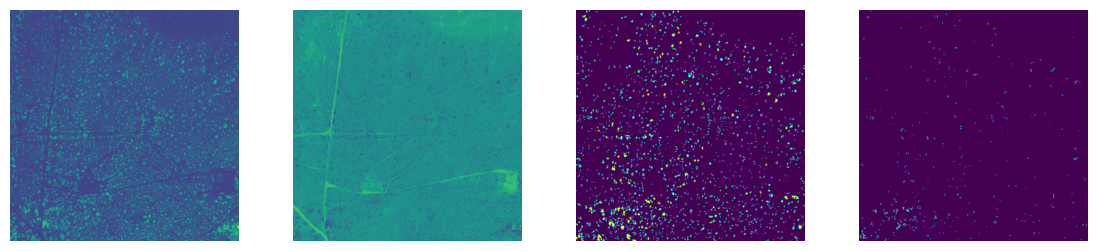

In [11]:
# Display extracted image
sampleImage = '_0.png'
fn = os.path.join(config.path_to_write, config.extracted_ndvi_filename + sampleImage )

ndvi_img = Image.open(fn)
pan_img = Image.open(fn.replace(config.extracted_ndvi_filename ,config.extracted_pan_filename))
read_ndvi_img = np.array(ndvi_img)
read_pan_img = np.array(pan_img)
annotation_im = Image.open(fn.replace(config.extracted_ndvi_filename ,config.extracted_annotation_filename))
read_annotation = np.array(annotation_im)
weight_im = Image.open(fn.replace(config.extracted_ndvi_filename ,config.extracted_boundary_filename))
read_weight = np.array(weight_im)
all_images = np.array([read_ndvi_img, read_pan_img, read_annotation, read_weight ])

display_images(np.expand_dims(np.transpose(all_images, axes=(1,2,0)), axis=0))
# plt.imshow(read_weight)